<a href="https://colab.research.google.com/github/cjk5642/ApexLegendsQuery/blob/main/tasks/task1(revisited).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import cosine
from tqdm import tqdm


data_folder = r"/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data"
files = os.listdir(data_folder)
overall_cutoff = 0.25
print(files)

def clean_raw_data(json_data, data_dir = data_folder, filename = 'raw_data.csv'):
  raw = pd.read_csv(os.path.join(data_folder, filename), usecols = ['Subject', 'Word1', 'Word2', 'Clue1', 'Level', 'Player1.RT', 'Board', 'Player2.ACC'])
  raw.loc[:, 'Board'] = raw.loc[:, 'Board'].apply(lambda x: int(x.lstrip('TrialList')))
  raw[['Experiment', 'Trial']] = raw['Subject'].str.split('.', expand = True)
  raw.loc[:, 'Experiment'] = raw.loc[:, 'Experiment'].apply(lambda x: int(x.lstrip('E')))
  raw = raw.drop('Subject', axis = 1)
  raw['key_id'] = 'e' + raw['Experiment'].astype(str) + '_board' + raw['Board'].astype(str) + '_words'
  raw['board_words'] = raw['key_id'].apply(lambda x: json_data[x])
  return raw

def create_processed_dir(dir_name = 'Processed'):
  path = os.path.join(data_folder, dir_name)
  if not os.path.isdir(path):
    os.makedirs(path)
    return path
  else:
    return path

def create_similars_dir(dir_name = "Similars", path = os.path.join(data_folder, 'Processed')):
  j_path = os.path.join(path, dir_name)
  if not os.path.isdir(j_path):
    os.makedirs(j_path)
    return j_path
  else:
    return j_path

def create_cutoff_dir(dir_name = 'Cutoffs', path = os.path.join(data_folder, 'Processed')):
  j_path = os.path.join(path, dir_name)
  if not os.path.isdir(j_path):
    os.makedirs(j_path)
    return j_path
  else:
    return j_path

processed_path = create_processed_dir()
similars_path = create_similars_dir(path = processed_path)
cutoff_path = create_cutoff_dir(path = processed_path)

with open(os.path.join(data_folder, 'boards.json'), 'r') as f:
  boards = json.loads(f.read())
raw_data = clean_raw_data(json_data = boards)
vocab = pd.read_csv(os.path.join(data_folder, 'vocab.csv'))
glove = pd.read_csv(os.path.join(data_folder, 'glove_embeddings.csv'))

['raw_data.csv', 'boards.json', 'glove_embeddings.csv', 'vocab.csv', 'swow_embeddings.csv', 'Processed', 'connector_clues.csv']


In [ ]:
def calculate_cosine(x1, x2):
  a = glove[x1]
  b = glove[x2]
  cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
  return cos_sim

def num_sim_words(word_data: pd.DataFrame, cutoff = 0.85):
  # get word pair
  # for each word pair, calculate the cosine similarity to another word on the board
  path = os.path.join(similars_path, f"similars{int(cutoff*100)}.csv")
  if not os.path.exists(path):
    collection = []
    for i in range(len(word_data)):
      word1 = word_data.loc[i, 'Word1']
      difficulty = word_data.loc[i, "Level"]
      word2 = word_data.loc[i, 'Word2']
      board_words = word_data.loc[i, 'board_words']
      experiment = word_data.loc[i, 'Experiment']
      trial = word_data.loc[i, 'Trial']

      words = {}
      words['Level'] = difficulty
      words['Experiment'] = experiment
      words['Trial'] = trial
      
      for i, w in enumerate([word1, word2]):
        words[f"Word{i+1}"] = w
        words[f'SimilarWords{i+1}'] = []
        count = 0
        for b in board_words:
          if word1 != b and word2 != b:
            res = calculate_cosine(w, b)
            if res >= cutoff:
              count += 1
              words[f'SimilarWords{i+1}'].append(b)
        words[f'SimilarWords{i+1}'] = ', '.join(words[f'SimilarWords{i+1}'])
        words[f"Count{i+1}"] = count
      words['Distractors'] = words["Count1"] + words["Count2"]
      words['Cutoff'] = cutoff
      collection.append(words)
    
      # store data in a data frame
    collection_frame = pd.DataFrame.from_dict(collection)
    
    collection_frame.to_csv(path, index = False)
    # concat data frame to total dataframe based on experiemtn and trial numbers
  else:
    collection_frame = pd.read_csv(path)
  
  return collection_frame

def run_multiple_similars(raw_data, num_cutoff = 10):
  values = np.around(np.linspace(0, 1, num=num_cutoff), decimals = 2)
  num_path = os.path.join(cutoff_path, f'cutoff{num_cutoff}.csv')
  if not os.path.exists(num_path):
    frames = []
    for v in tqdm(values):
      frame = num_sim_words(raw_data, cutoff = v)
      frame = frame[['Word1', 'Count1', 'Word2', 'Count2', 'Cutoff']].drop_duplicates()
      frames.append(frame)
    collected = pd.concat(frames).sort_values(['Word1', 'Word2', 'Cutoff']).reset_index(drop = True)
    collected.to_csv(num_path, index = False)
  else:
    collected = pd.read_csv(num_path)
  
  return collected

def plot_multiple_similars(cutoffs):
  pairs = cutoffs[['Word1', 'Word2']].drop_duplicates().reset_index(drop = True)
  frames = []
  for i in range(len(pairs)):
    word1, word2 = pairs.loc[i, 'Word1'], pairs.loc[i, 'Word2']
    temp = cutoffs[(cutoffs['Word1'] == word1) & (cutoffs['Word2'] == word2)]
    temp1 = pd.melt(temp, id_vars = ['Cutoff', 'Word1'], value_vars=['Count1']).rename({"Word1": "Word", 'value': 'Count'}, axis = 1).drop('variable', axis = 1)
    temp2 = pd.melt(temp, id_vars = ['Cutoff', 'Word2'], value_vars=['Count2']).rename({"Word2": "Word", 'value': 'Count'}, axis = 1).drop('variable', axis = 1)
    total = pd.concat([temp1, temp2], axis = 0)
    sns.lmplot(x = 'Cutoff', y = 'Count', hue = 'Word', data = total, palette = 'Set1')
    plt.show()

def board_similarity(raw: pd.DataFrame, glove: pd.DataFrame):
  reduced = raw[['Board', 'Experiment', 'board_words']]
  reduced['board_words'] = reduced['board_words'].apply(lambda x: ','.join(x))
  reduced = reduced.drop_duplicates()
  reduced = reduced.sort_values(['Experiment', 'Board']).reset_index(drop = True)
  reduced['board_words'] = reduced['board_words'].apply(lambda x: x.split(','))
  
  data_dicts = []
  for i in range(len(reduced)):
    ddict = {}
    ddict['Board'] = reduced.loc[i, 'Board']
    ddict['Experiment'] = reduced.loc[i, 'Experiment']
    board = reduced.loc[i, 'board_words']
    board_dat = np.zeros((len(board), len(board)))
    for b1 in range(len(board)):
      for b2 in range(len(board)):
        if b1 < b2:
          result = calculate_cosine(board[b1], board[b2])
          board_dat[b1, b2] = result
        else:
          board_dat[b1, b2] = None

    board_d = pd.DataFrame(board_dat, columns = board, index = board)
    ddict['Frame'] = board_d
    data_dicts.append(ddict)
  total = pd.DataFrame.from_dict(data_dicts)
  return total

def plot_board(board: int, experiment: int, data: pd.DataFrame):
  assert board in data['Board'] or board == 'all', 'Board number must be between 1-10, or all'
  assert experiment in data['Experiment'] or experiment == 'all', 'Experiment number must be 1 or 2, or all'
  if board == 'all':
    assert experiment == 'all', 'Experiment and Board both must be all to run'

  if board != 'all' and experiment != 'all':
    idx = data.loc[(data['Board'] == board) & (data['Experiment'] == experiment)].index[0]
    sample = data.loc[idx, 'Frame']

    fig, ax = plt.subplots(figsize = (12, 8))
    plt.imshow(sample, aspect = 'auto', cmap = 'Reds')
    cols = sample.columns.to_list()
    plt.xticks(ticks = range(len(cols)), labels = cols, rotation = 90)
    plt.yticks(ticks = range(len(cols)), labels = cols)
    plt.colorbar()
    plt.grid()
    plt.title(f"Cosine Similarity for Board {board} and Experiment {experiment}", fontsize = 20)
    plt.show()
  else:
    for i in range(len(data)):
      b = data.loc[i, 'Board']
      e = data.loc[i, 'Experiment']
      plot_board(b, e, data)


In [ ]:
similars = num_sim_words(raw_data, cutoff = overall_cutoff)

In [ ]:
multiple20 = run_multiple_similars(raw_data, num_cutoff=20)
multiple20

,Word1,Count1,Word2,Count2,Cutoff
0,army,18,drum,18,0.00
1,army,17,drum,17,0.05
2,army,15,drum,16,0.11
3,army,11,drum,13,0.16
4,army,6,drum,7,0.21
...,...,...,...,...,...
1195,weird,0,trauma,0,0.79
1196,weird,0,trauma,0,0.84
1197,weird,0,trauma,0,0.89
1198,weird,0,trauma,0,0.95


2.	I’d also like to see how the number of distractors change as a function of the cutoff – so, if we use a higher cutoff (say .50 instead of .25), what is the pattern – plot the number of distractors (Y) as a function of cutoff (X) for both W1 and W2, and fit a linear regression line for both words.

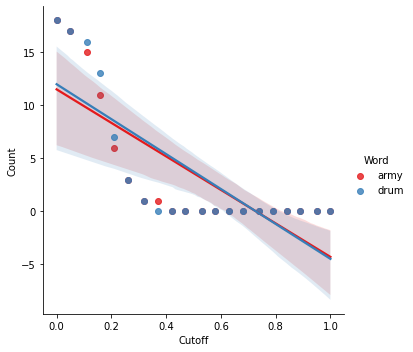

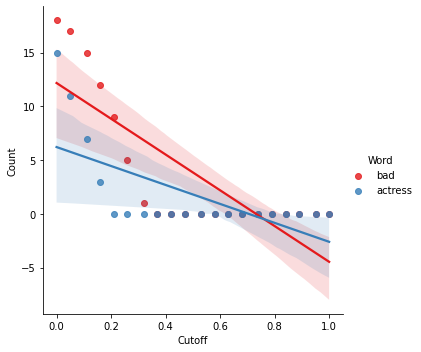

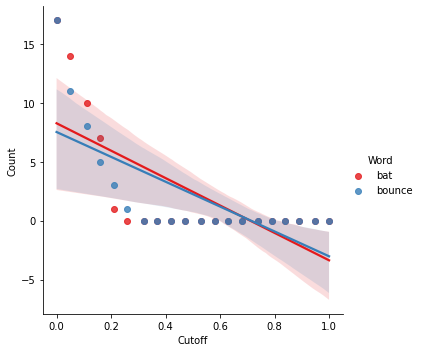

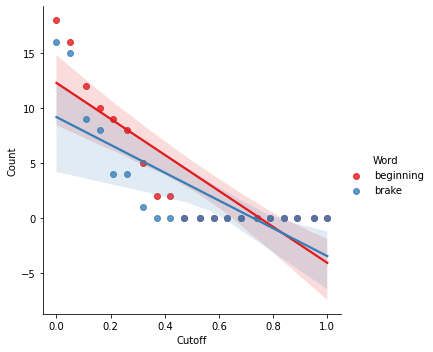

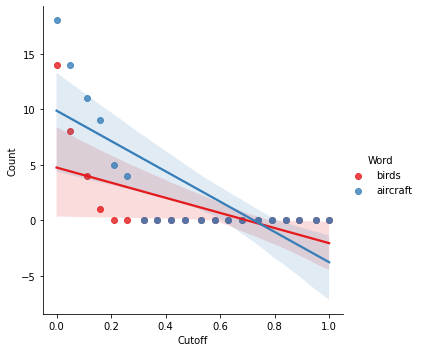

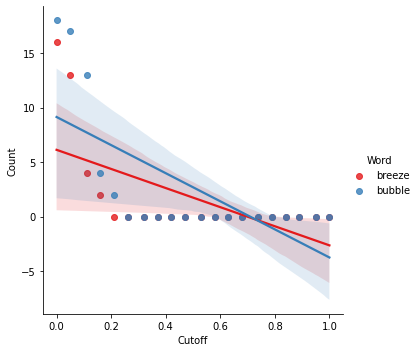

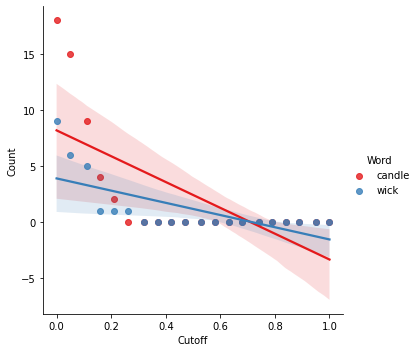

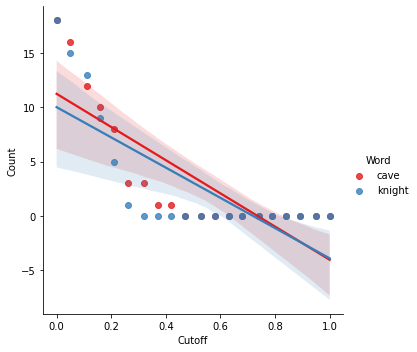

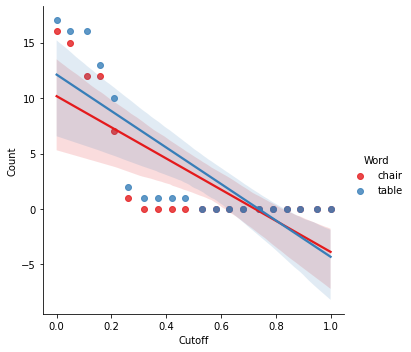

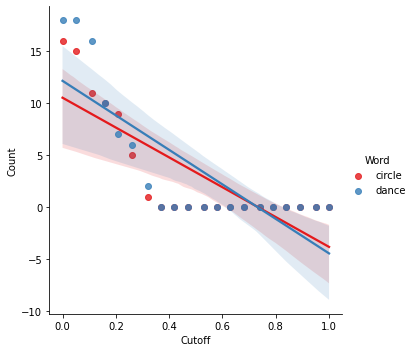

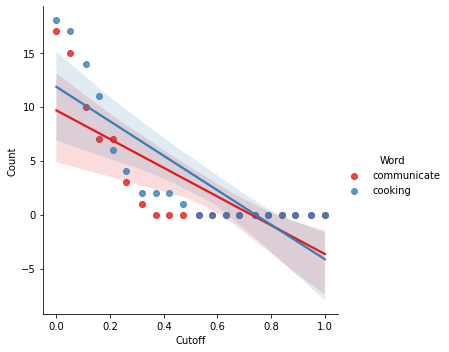

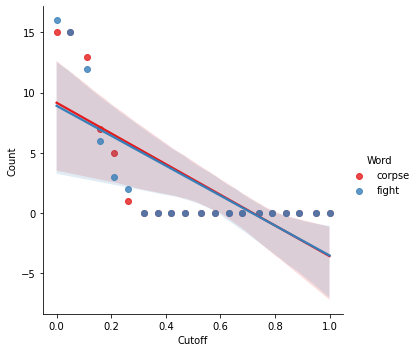

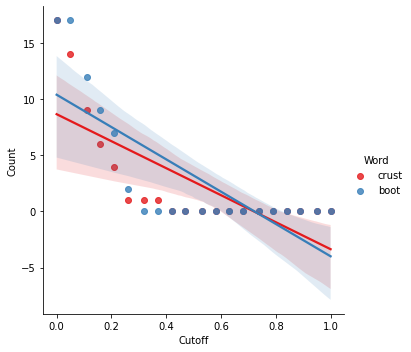

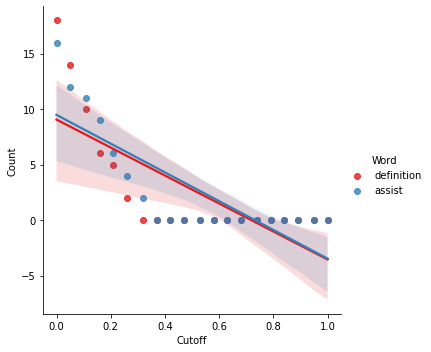

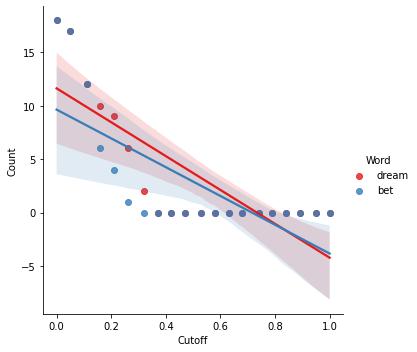

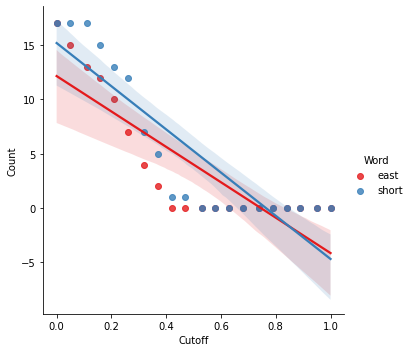

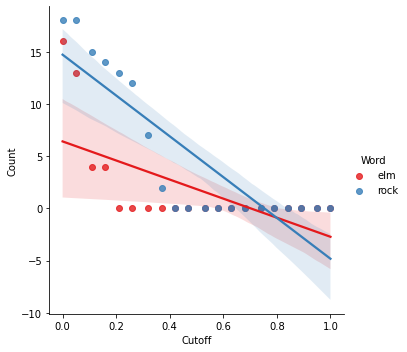

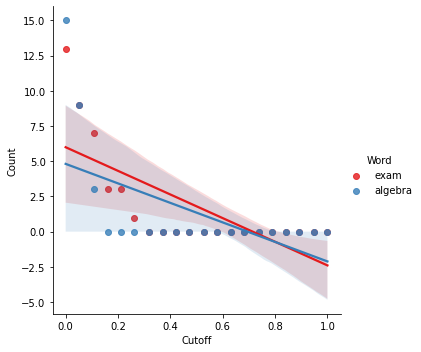

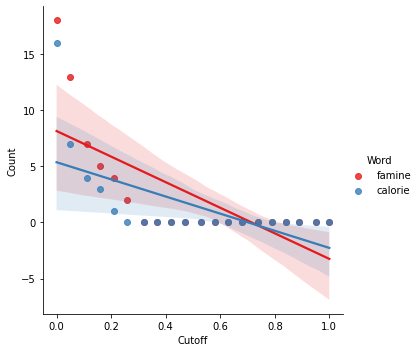

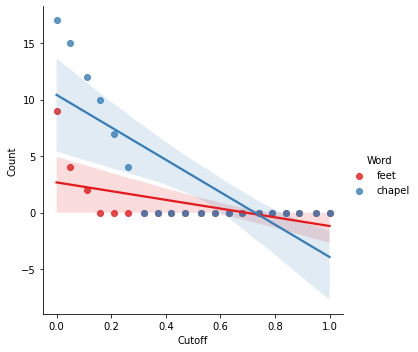

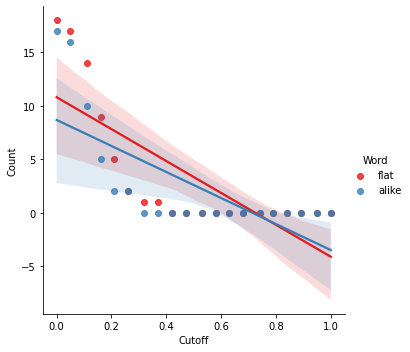

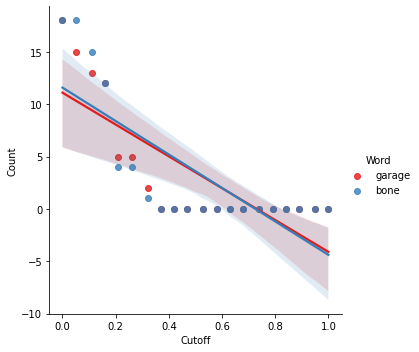

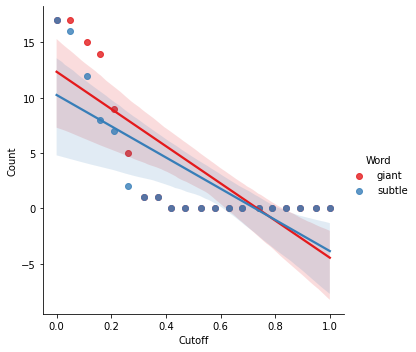

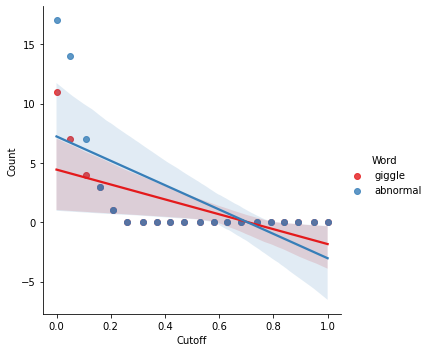

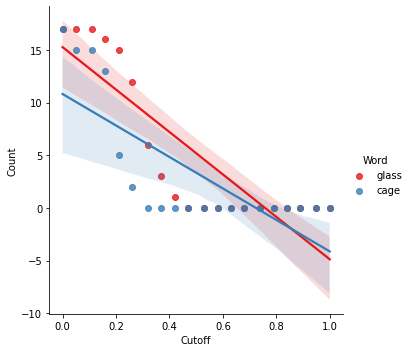

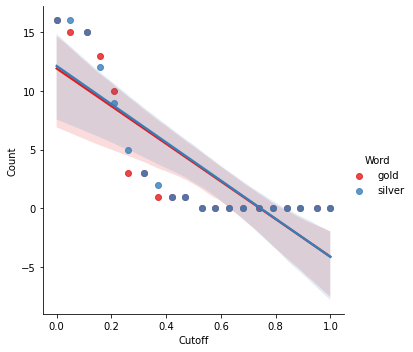

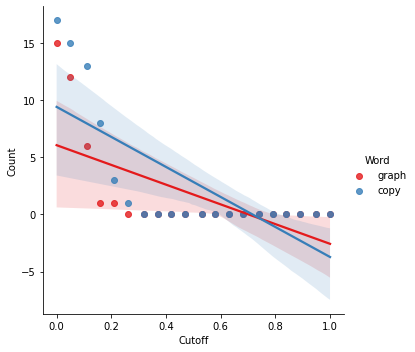

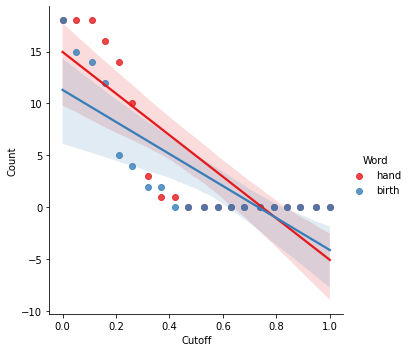

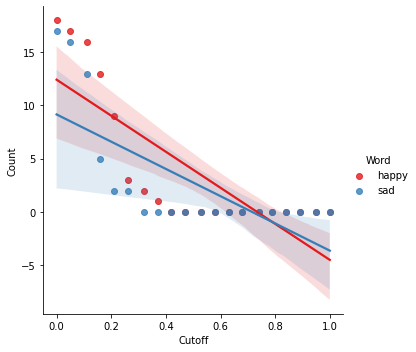

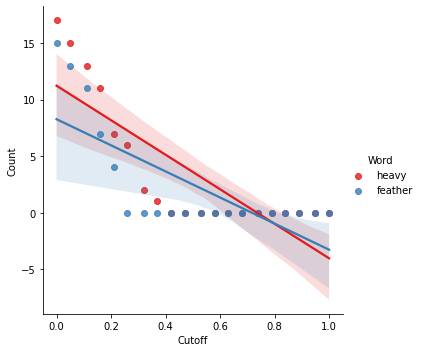

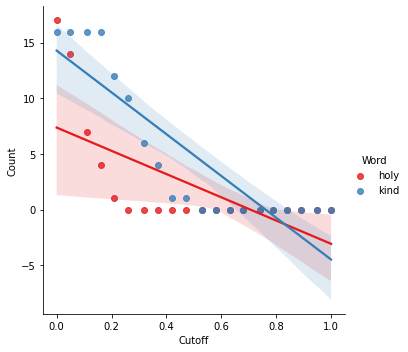

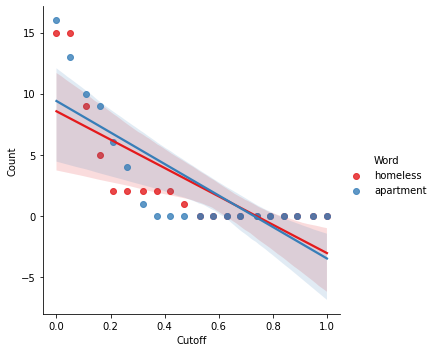

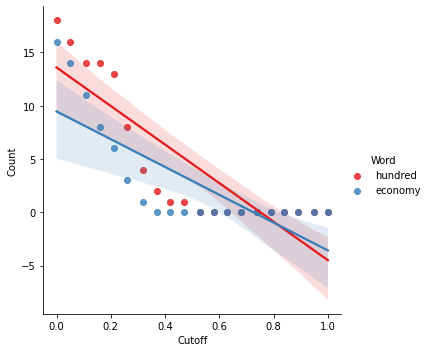

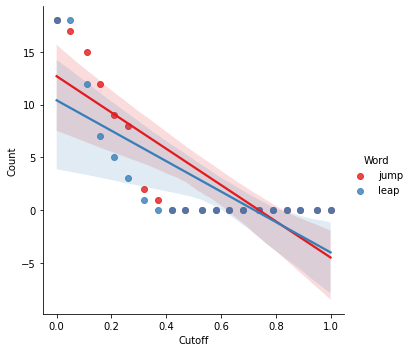

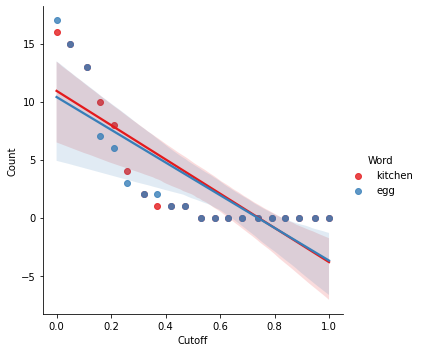

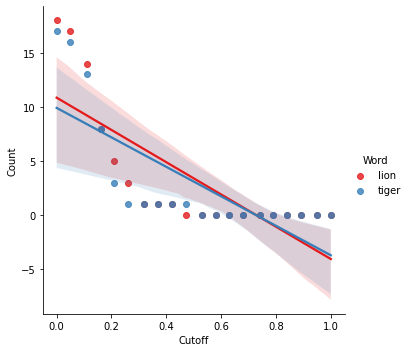

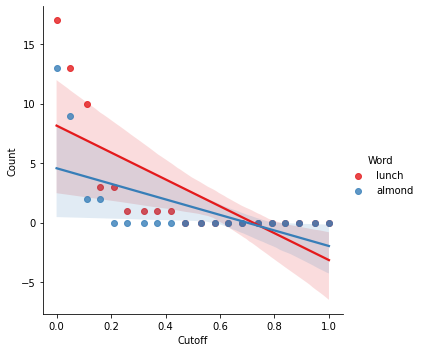

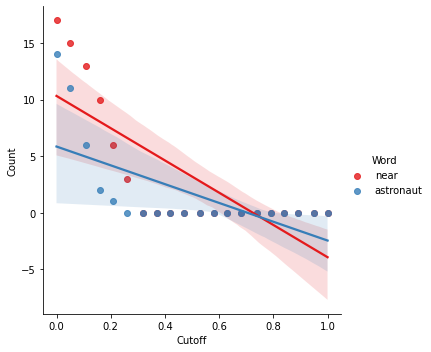

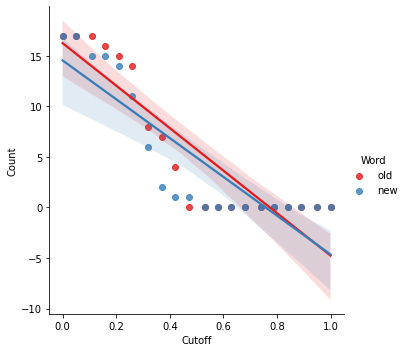

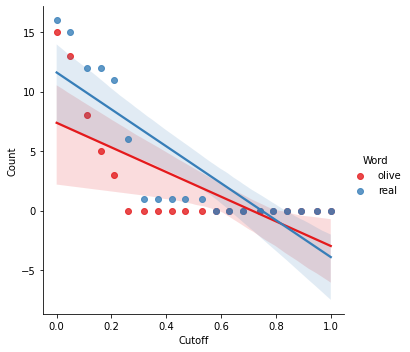

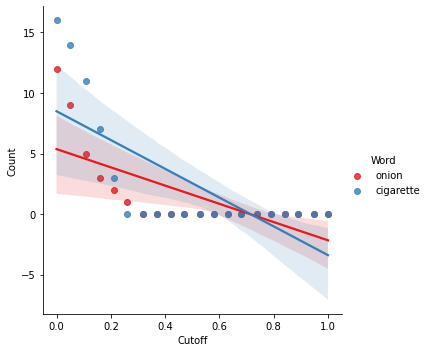

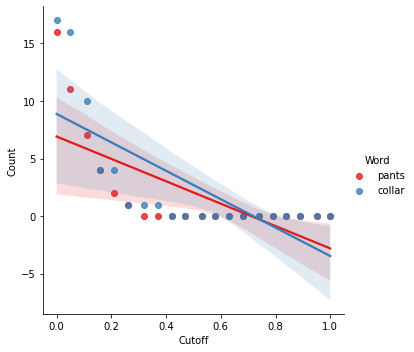

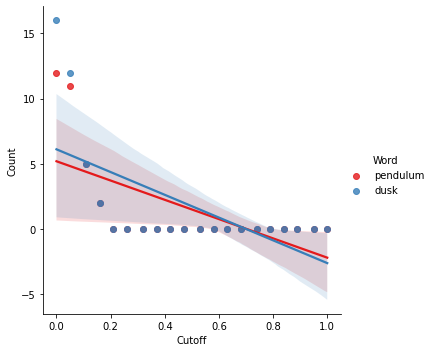

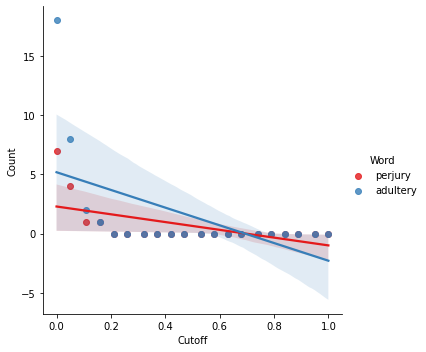

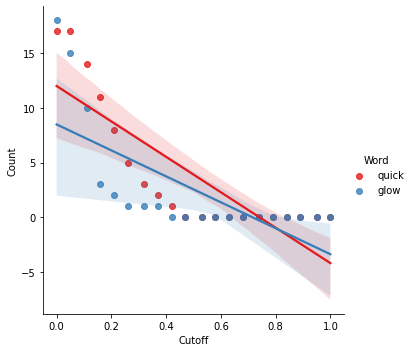

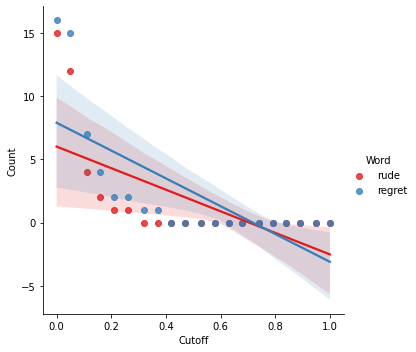

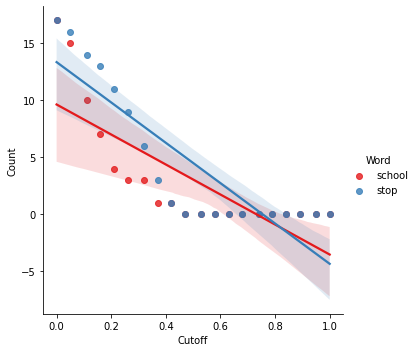

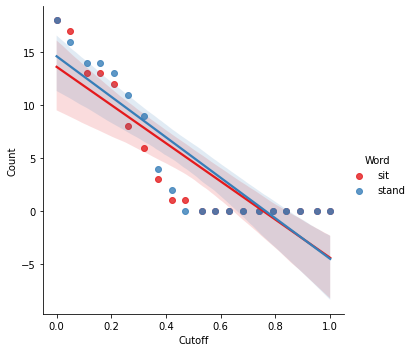

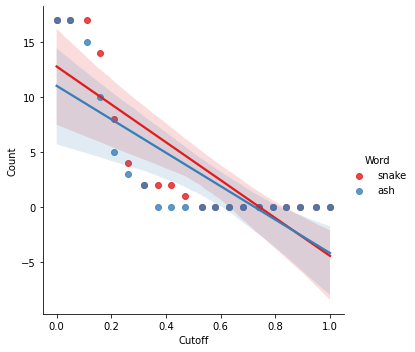

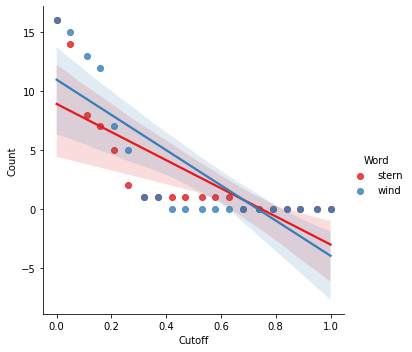

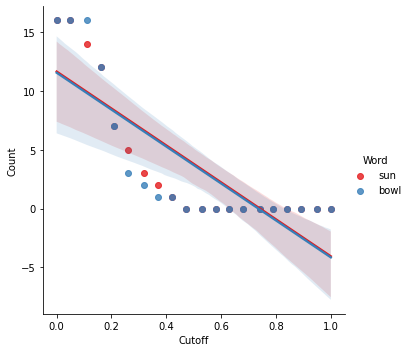

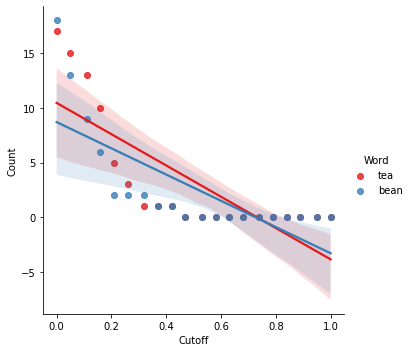

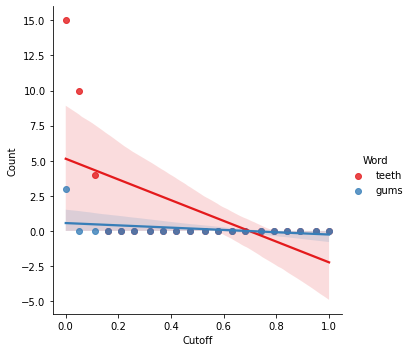

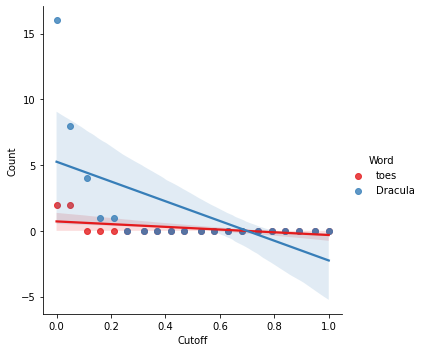

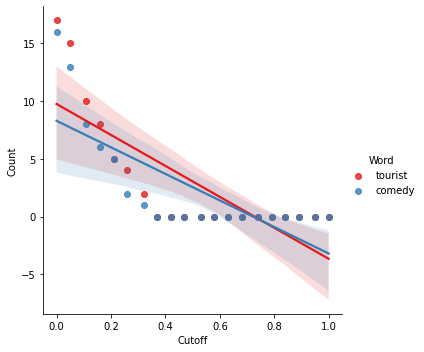

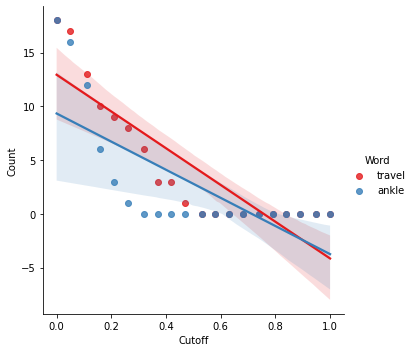

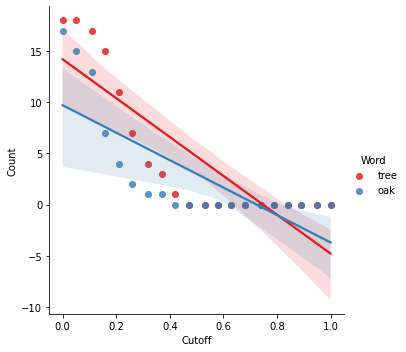

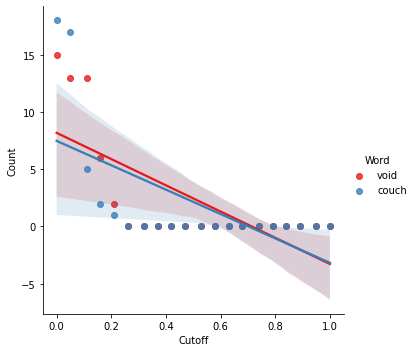

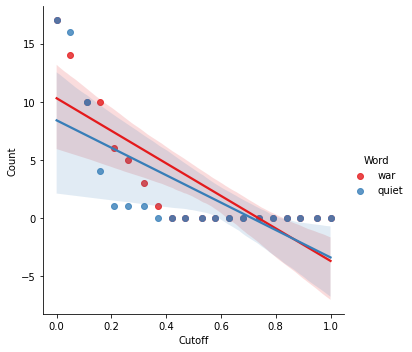

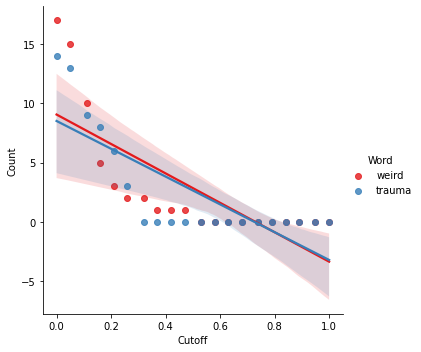

In [ ]:
plot_multiple_similars(multiple20)

3.	So, it seems that experiment 2 had a lot of distractors compared to experiment 1 – is that your general understanding? One thing I remember we did was try to pick more common words for the boards in experiment 2, so maybe that’s why – can you look at the overall frequency of the words is for each board in E1 and E2, and whether that correlates with number of distractors? 

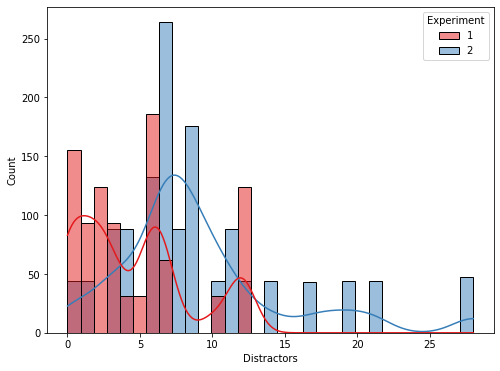

In [ ]:
raw_data.loc[:, 'Trial'] = raw_data.loc[:, 'Trial'].astype(int)
joined_raw = raw_data.merge(similars, on = ['Level', 'Experiment', 'Trial', 'Word1', 'Word2'])
joined_raw['DistractorRatio'] = joined_raw['Distractors']/(2*18)

exp1 = joined_raw[joined_raw['Experiment'] == 1].reset_index(drop = True)['Distractors']
exp2 = joined_raw[joined_raw['Experiment'] == 2].reset_index(drop = True)['Distractors']

exp1_dict = {'Distractors': exp1, 'Experiment': 1}
exp2_dict = {'Distractors': exp2, 'Experiment': 2}

comb = pd.concat([pd.DataFrame(exp1_dict), pd.DataFrame(exp2_dict)], ignore_index=True)

fig, ax = plt.subplots(figsize = (8, 6))
sns.histplot(data = comb, x = 'Distractors', hue = 'Experiment', kde = True, palette='Set1', ax = ax)
plt.show()

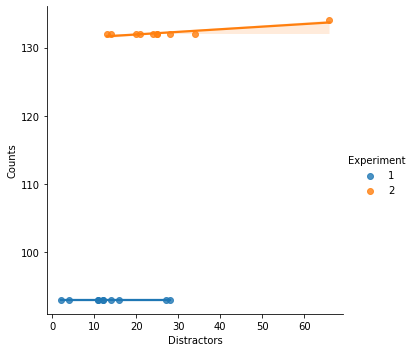

In [ ]:
jr = joined_raw[['Board', 'Experiment', 'Word1', 'Word2', 'Distractors']].value_counts().reset_index().ffill().drop_duplicates().rename({0: "Counts"}, axis = 1)
jf = jr.groupby(['Board', 'Experiment']).sum().reset_index().ffill()
#fig, ax = plt.subplots(figsize = (8, 6))
sns.lmplot(data = jf, x = 'Distractors', y = 'Counts', hue = 'Experiment')
plt.show()

4.	I don’t fully understand your second plot of Count1 vs. Count 2 – maybe add a text section trying to explain what you did and what information we can derive from this plot?


This plot can show us the number of distractors per word pair where Count 1 is for the first word in the word pair and Count 2 the same. For example, in the plot and word pair *(elm, rock)* we can see that *elm* had 0 distractors were *rock* had 12 distractors. It is colored yellow since it was medium level, whereas green is easy and red is hard. This can show us if there were many distractors per level of difficulty.

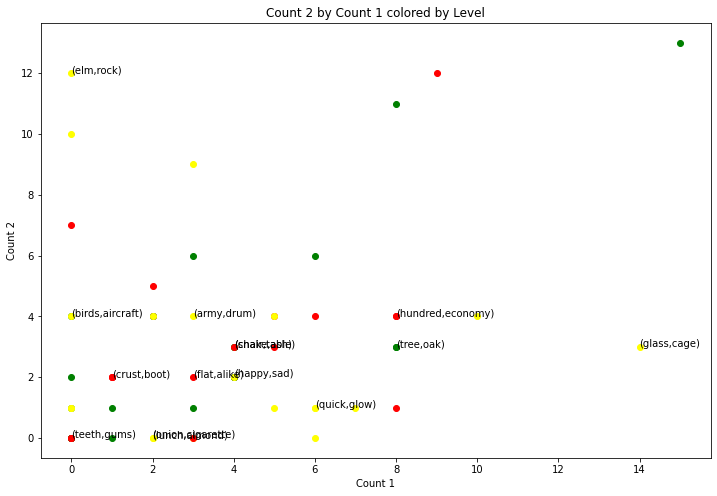

In [ ]:
temp1 = similars.groupby(['Word1', 'Word2', 'Level']).median().reset_index().ffill()
temp1['pair'] = "(" + temp1['Word1'] + ',' + temp1['Word2'] + ")"
temp1 = temp1.drop(['Word1', 'Word2', 'Experiment'], axis = 1)

colors = {'Easy': 'green', 'Medium': 'yellow', 'Hard': 'red'}
temp1['colors'] = temp1['Level'].apply(lambda x: colors[x])

fig, ax = plt.subplots(figsize = (12, 8))
for i in range(len(temp1)):
  row = temp1.loc[i, :]
  plt.scatter(row['Count1'], row['Count2'], c = row['colors'])

  if i % 4 == 0:
    plt.annotate(row['pair'], (row['Count1'], row['Count2']))
plt.xlabel('Count 1')
plt.ylabel('Count 2')
plt.title("Count 2 by Count 1 colored by Level")
plt.show()

5.	For the accuracy-based analyses, what I was hoping we could look at is whether the total proportion of distractors correlates with player2 accuracy. So, for this analysis, for each board, you would calculate the average accuracy and also calculate the average number of distractors, and fit a linear regression model on these data. Alternatively, you could use the full dataset and fit a logistic regression model predicting player2.acc with “distractors” – make sure you use a mixed effects model here so you are accounting for subject-level variance. Finally, the plot should be a line plot, where you are predicting player2.acc from the distractors and the line reflects the line of best fit you obtain from the linear or logistic regression. Essentially, we want to know if people are more or less accurate (on a continuum of 0 to 1) if there are more distractors on the board. 

In [ ]:
subj = joined_raw.groupby(['Board', 'Experiment', 'Word1', 'Word2']).mean().reset_index().ffill()
subj = subj.drop(['Trial', 'Count1', 'Count2', 'Cutoff', 'DistractorRatio'], axis = 1)
subj = subj.rename({"Player2.ACC": "Player2ACC"}, axis = 1)

factors = subj[['Distractors', 'Player2ACC']]
factors.loc[:, 'Player2ACC'] = np.around(factors.loc[:, 'Player2ACC'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


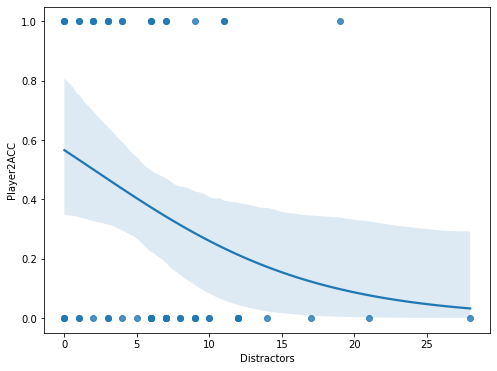

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.regplot(x='Distractors', y='Player2ACC', data=factors, logistic=True, ax = ax)
plt.show()

6.	I really like your board grid plot at the end! It gives a good overall picture of board-level similarities. Any way for us to look at all the boards at once? This would give us a sense of what the “overall” pattern looks like and which boards look more different from the rest.



In [ ]:
total = board_similarity(raw_data, glove)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


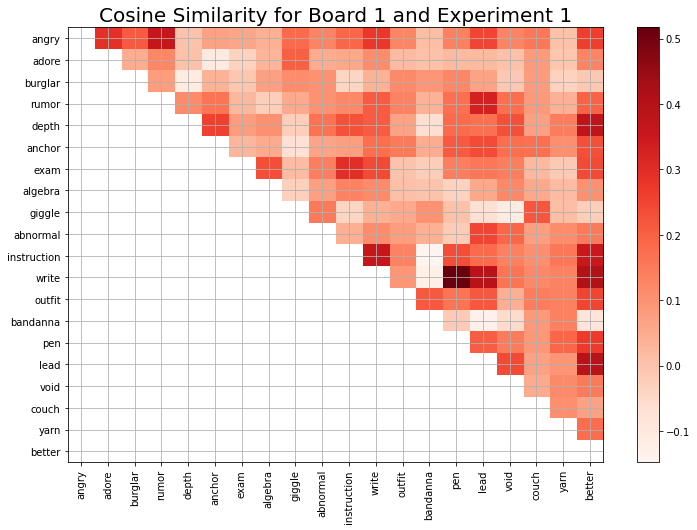

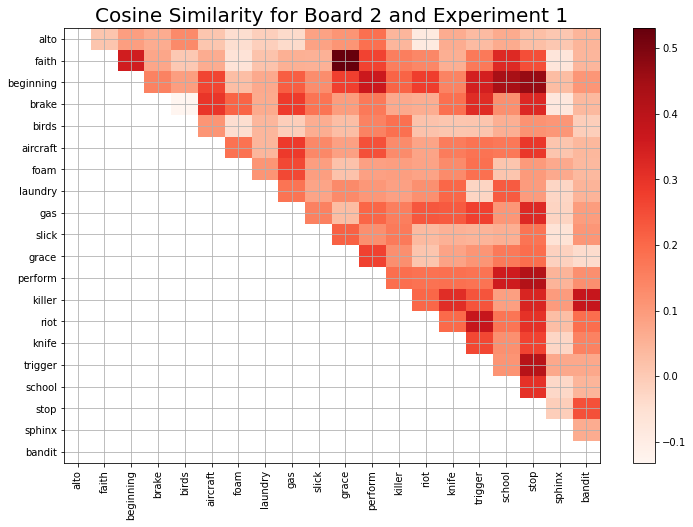

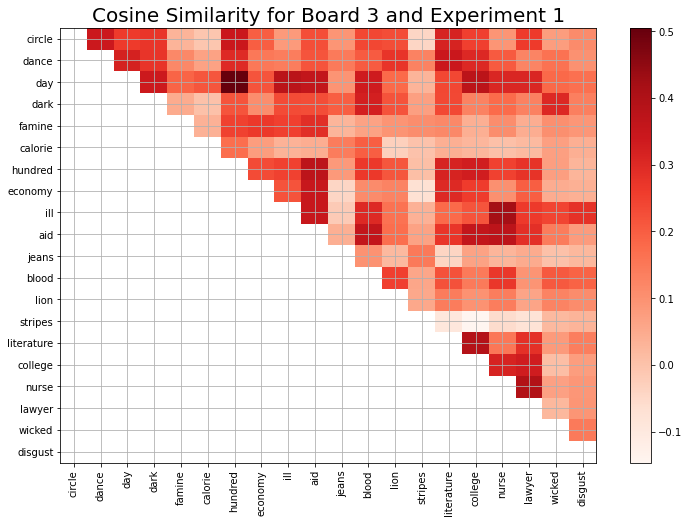

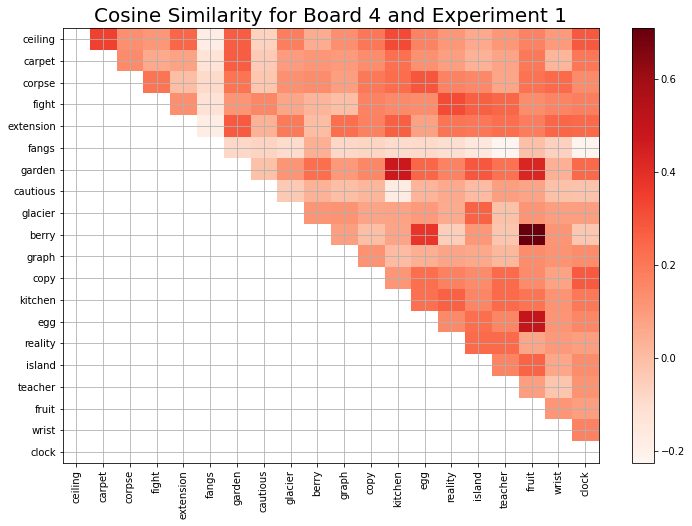

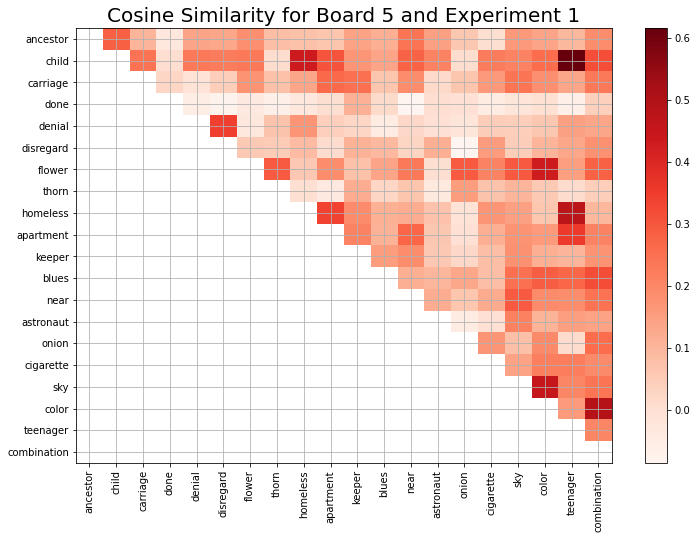

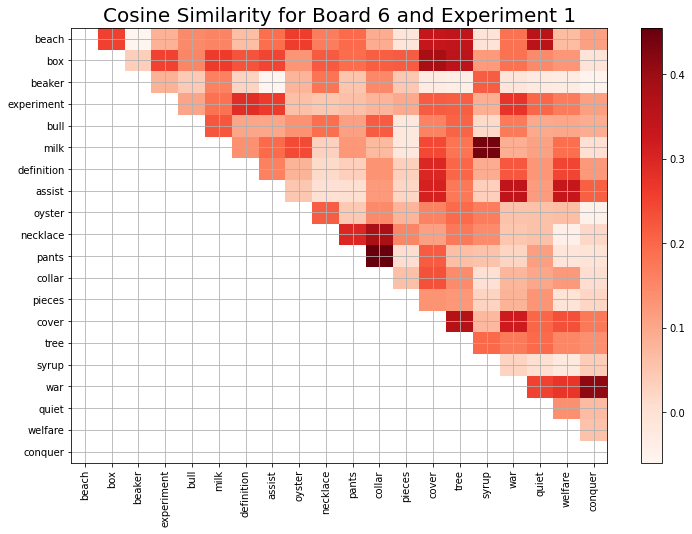

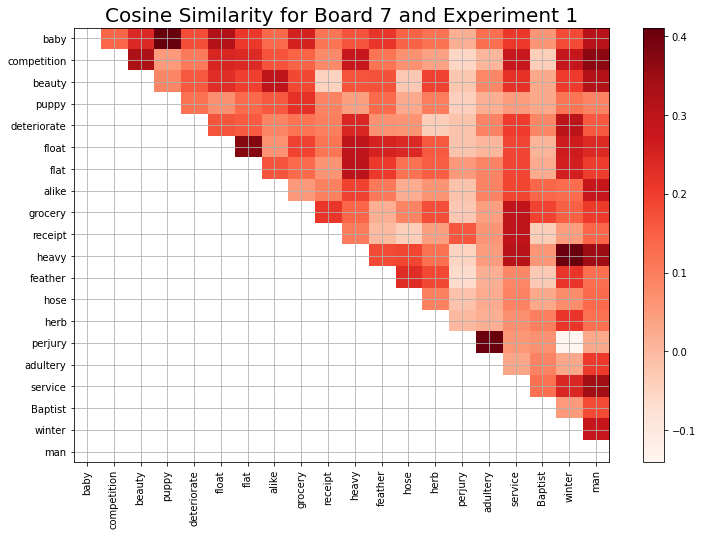

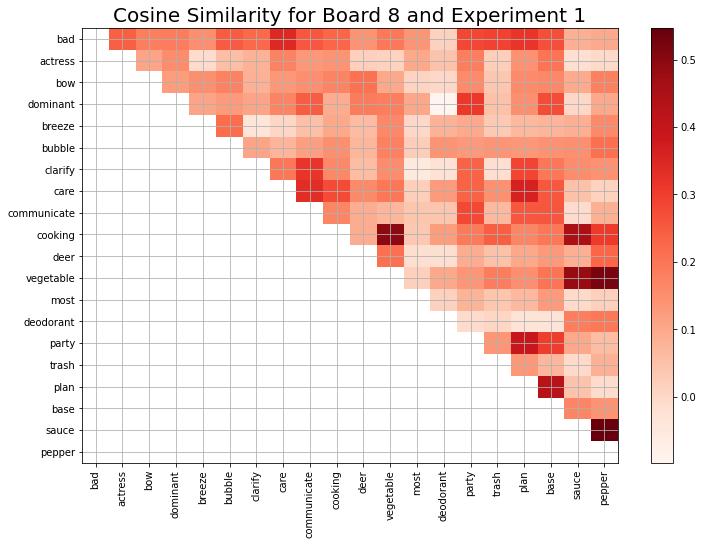

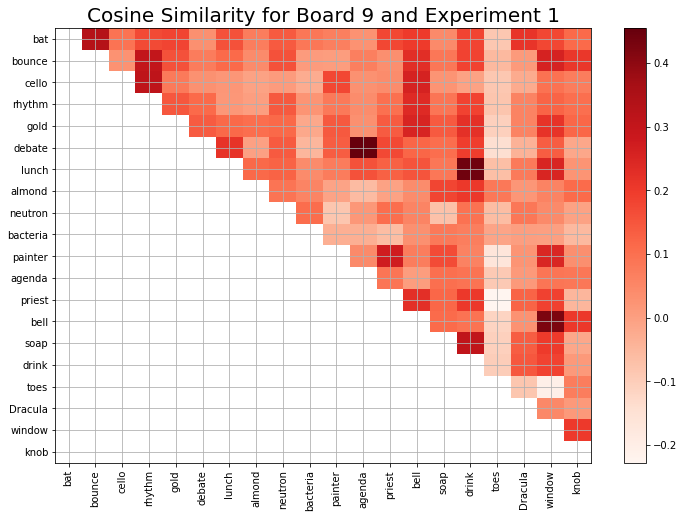

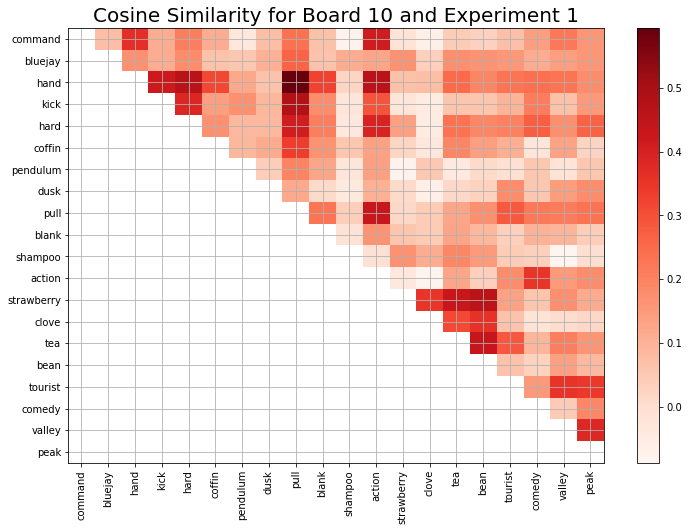

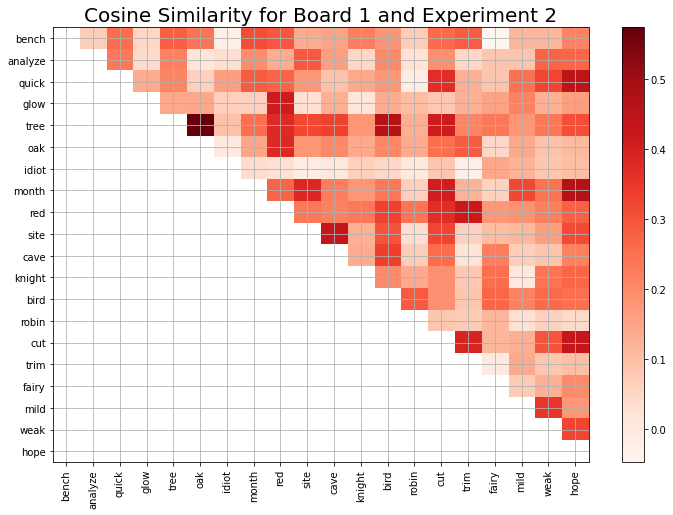

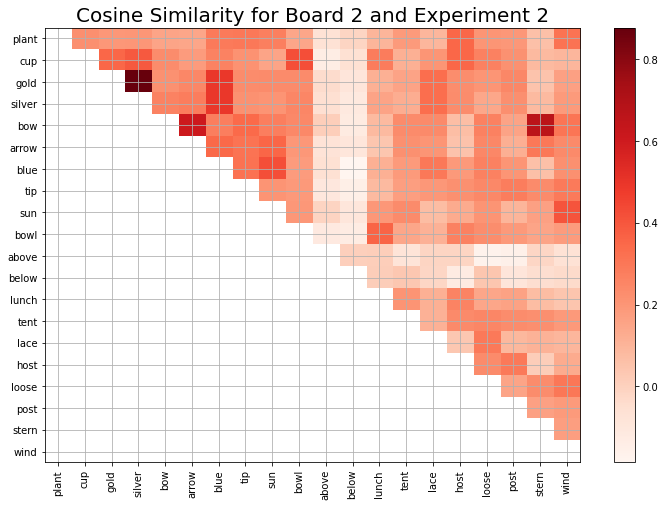

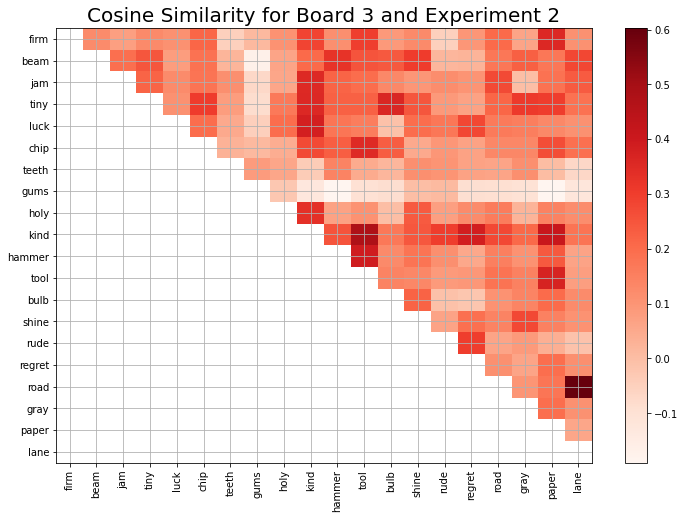

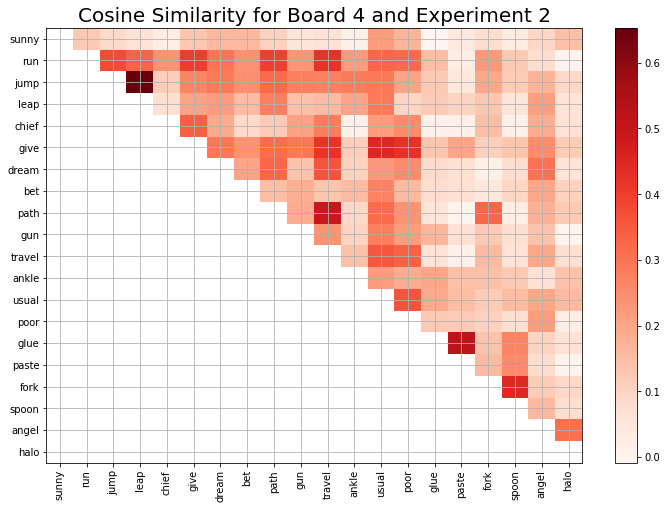

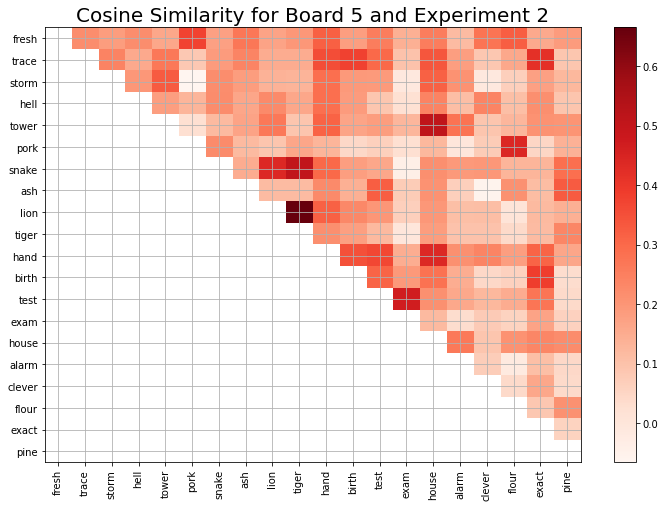

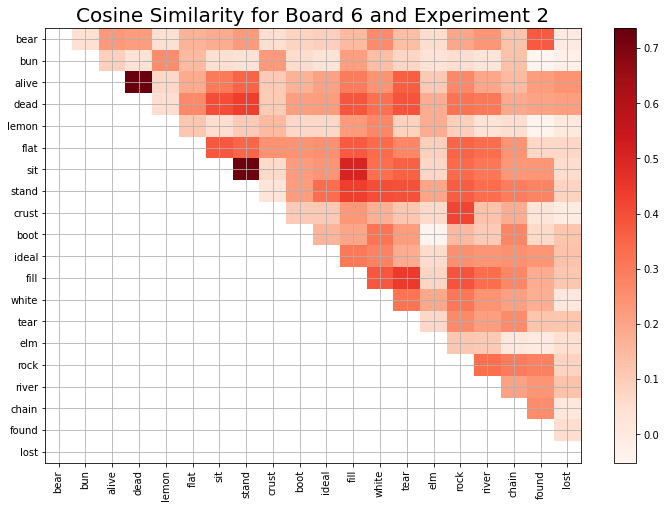

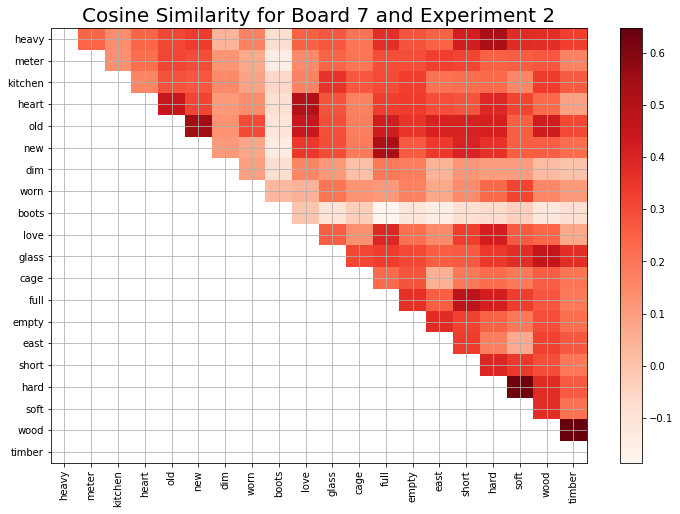

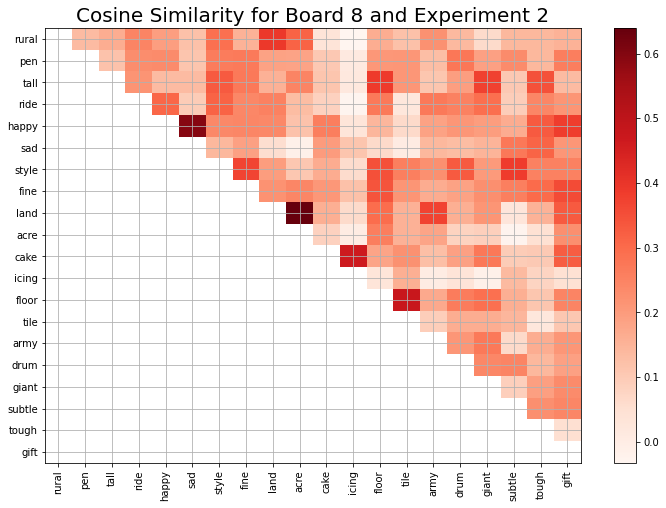

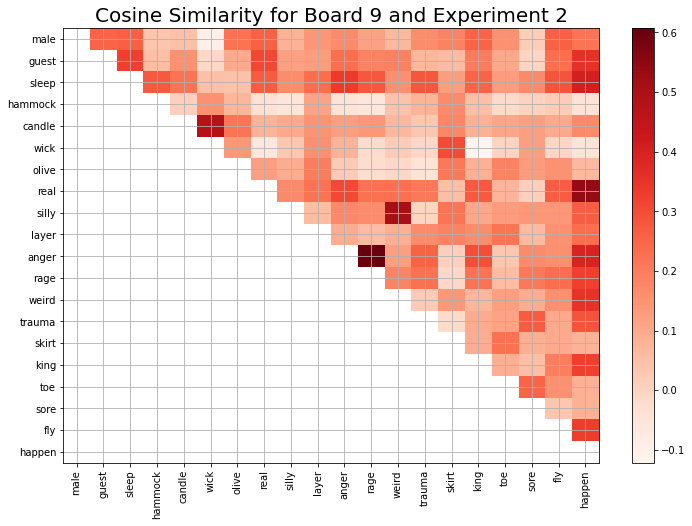

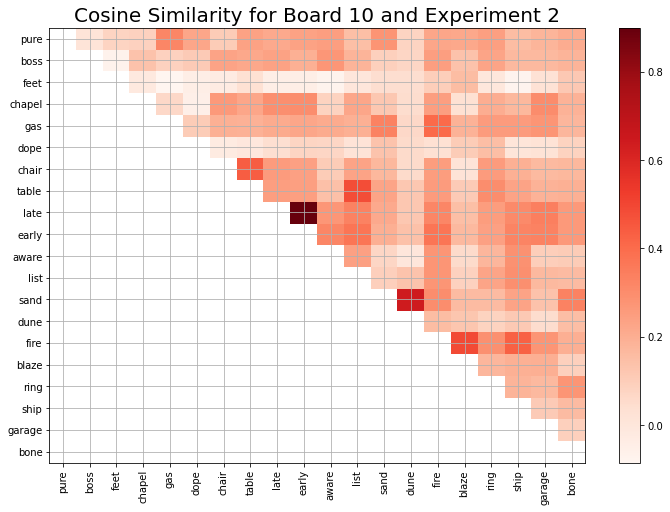

In [ ]:
plot_board('all', 'all', total)

7.	Going forward, I think it’d also be good practice for you to write-up a 1-line summary of what you think the analyses are reflecting, so that you are thinking critically about the data and we both know how you were interpreting the plot. 
